In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
import seaborn as sns

**DATA STRUCTURE**

This code loads the Mona2023 Excel file into a pandas DataFrame. We ensure that the comma decimal separators are correctly interpreted. We clean the data frame by removing  empty columns, and we rename a column to 'Indicator' for clarity. We transpose the data frame so that the rows (time periods) become columns (now representing different indicators or variables). The transposed data frame has its first row (now containing the indicators' names) set as column headers for easier data manipulation. The cleaned and transposed data frame is then saved to a new Excel file (cleaned_and_transposed_monadata2023.xlsx) and the first ten rows are displayed. 

In [2]:
# Loading the dataset, use the correct decimal handling
mona_data = pd.read_excel('monadata2023.xlsx', decimal=',')

# Drop any empty columns to clean the dataset
mona_data.dropna(axis=1, how='all', inplace=True)

# Rename the first column for clarity
mona_data.rename(columns={'Unnamed: 0': 'Indicator'}, inplace=True)

# Transpose the dataset to have indicators as columns and quarters as rows
mona_data_transposed = mona_data.T

# Rename the first row after transposing if it's needed
mona_data_transposed.rename(columns=mona_data_transposed.iloc[0], inplace=True)
mona_data_transposed.drop(mona_data_transposed.index[0], inplace=True)

# Save the cleaned and transposed data
mona_data_transposed.to_excel('cleaned_and_transposed_monadata2023.xlsx', index=True)

mona_data_transposed.head(10)

,tttt,d100q1,d7734,d78q4,d8081,d88q1,dmims,drad,dral,dtye_,...,logywby,logywla,logywo,dlogfyfbx,dlogws_z_h,fcpw,kbw,dtkbw,gfcp,gfipbxe
1971q1,1.971,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,3.915119,0.169817,3.006204,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1971q2,1.97125,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,3.933617,0.140318,3.013863,-0.009158,NaN,NaN,NaN,0.0,NaN,NaN
1971q3,1.9715,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,3.94949,0.112452,3.083522,-0.007943,NaN,NaN,NaN,0.0,NaN,NaN
1971q4,1.97175,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,3.965134,0.146839,3.091395,-0.009509,NaN,NaN,NaN,0.0,NaN,NaN
1972q1,1.972,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,3.991326,0.167208,3.128989,0.011746,NaN,NaN,NaN,0.0,NaN,NaN
1972q2,1.97225,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,4.017188,0.186144,3.169424,0.038418,NaN,NaN,904.231712,0.0,NaN,NaN
1972q3,1.9725,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,4.044204,0.17873,3.216151,0.022967,NaN,NaN,920.163144,0.0,NaN,NaN
1972q4,1.97275,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,4.080434,0.167791,3.221065,-0.009002,NaN,NaN,910.598539,0.0,NaN,NaN
1973q1,1.973,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,4.104671,0.260679,3.256748,0.020354,NaN,NaN,925.457897,0.0,NaN,NaN
1973q2,1.97325,0.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,1.0,...,4.143921,0.260652,3.316224,-0.007862,0.137079,483.28889,914.910247,0.0,NaN,NaN


**VARIABLES**

This assignment is based on the data we use from one of our group member's BA-thesis. The goal is to structure a VAR model consisting of the variables interest rate (imm), output (fy), exchange rate (efkrks), and inflation (pcpdk) from the Danish Central Bank's MONA dataset. 

In the first part we load the dataset, which is given in Excel-format, and read it in python. We then transpose the dataset to better structure the data and have variables in the columns instead of rows. We also define the data as quarterly data. 
We define the variable names and run a dicky-fuller distribution test to check for stationarity and need for first-differencing.

Due to there being many empty cells in MONA we run a code to check and remove the NaNs and infs. Finally we print the ten first observations of the relevant variables in MONA.

In [3]:
# Convert the index to PeriodIndex with a quarterly frequency
mona_data_transposed.index = pd.PeriodIndex(mona_data_transposed.index, freq='Q')

# Replace variable_names with the actual variable names from your data
variable_names = ['imm', 'efkrks', 'fy', 'pcpdk']

# Function to check for stationarity and take first difference if necessary
def check_stationarity_and_difference(df, variable):
    series = df[variable].astype(float)  # Ensure the data type is float for the adfuller test
    result = adfuller(series.dropna())
    if result[1] > 0.05:  # Non-stationary, take first difference
        return series.diff().dropna()
    else:
        return series

# Apply the stationarity check and differencing to the relevant variables
for variable in variable_names:
    mona_data_transposed[variable] = check_stationarity_and_difference(mona_data_transposed, variable)

# Drop any rows that have NaN values resulting from differencing
mona_data_transposed.dropna(inplace=True)

# Make sure there are no infinite values in the dataset
mona_data_transposed.replace([np.inf, -np.inf], np.nan, inplace=True)
mona_data_transposed.dropna(inplace=True)

# Check if there are still any NaNs or infs in the data
assert not mona_data_transposed.isnull().values.any(), "NaN values detected"
assert not np.isinf(mona_data_transposed.values).any(), "Inf values detected"

# Print first ten observations
first_ten_observations_specific = mona_data_transposed[variable_names].head(10)
first_ten_observations_specific

,imm,efkrks,fy,pcpdk
1999Q1,-0.009606,-1.619633,14.3648,0.004825
1999Q2,-0.006411,-1.370333,8.2612,0.004900
1999Q3,-0.000876,-0.810967,9.9388,0.007011
1999Q4,0.002086,-0.908467,22.6328,0.006762
2000Q1,0.003593,-1.391600,15.9980,0.005763
2000Q2,0.006977,-1.289467,18.8596,0.005437
2000Q3,0.006059,-0.373733,4.6284,0.004047
2000Q4,0.004965,-0.336133,16.4284,0.006182
2001Q1,-0.000218,2.190333,-18.4200,0.003718
2001Q2,-0.000705,-0.834633,8.1924,0.006789


In this part we rename the variables to what they are known as in order to enhance readability. We again print the first ten observations, but with the renamed variables.

In [4]:
# Define a mapping for renaming variables to more descriptive names
variable_rename_map = {
    'fy': 'output',
    'imm': 'interest rate',
    'efkrks': 'exchange rate',
    'pcpdk': 'inflation'
}

# Rename the variables in the dataframe
mona_data_for_var = mona_data_transposed[variable_names]
mona_data_for_var_renamed = mona_data_for_var.rename(columns=variable_rename_map)

# Fit the VAR model with the renamed variables
var_model_renamed = VAR(mona_data_for_var_renamed)
var_results_renamed = var_model_renamed.fit(maxlags=2, ic='aic')

# Print first ten observations
first_ten_observations_renamed = mona_data_for_var_renamed.head(10)
first_ten_observations_renamed

,interest rate,exchange rate,output,inflation
1999Q1,-0.009606,-1.619633,14.3648,0.004825
1999Q2,-0.006411,-1.370333,8.2612,0.004900
1999Q3,-0.000876,-0.810967,9.9388,0.007011
1999Q4,0.002086,-0.908467,22.6328,0.006762
2000Q1,0.003593,-1.391600,15.9980,0.005763
2000Q2,0.006977,-1.289467,18.8596,0.005437
2000Q3,0.006059,-0.373733,4.6284,0.004047
2000Q4,0.004965,-0.336133,16.4284,0.006182
2001Q1,-0.000218,2.190333,-18.4200,0.003718
2001Q2,-0.000705,-0.834633,8.1924,0.006789


**IMPULSE RESPONSE FUNCTIONS**

The goal in the assignment is the analyze the effect a shock to the interest rate has on the other three defined variables. To do this we plot impulse response functions based on the VAR model we defined and fitted in the first code.
The impulse response functions indicate how different economic variables react to shocks over time. An interest rate shock initially leads to a positive response in interest rates, followed by a reversion towards the original state. The exchange rate shows a minimal response, while output and inflation decrease, suggesting that an increase in interest rates might suppress both economic activity and price levels. Shocks to other variables—exchange rate, output, and inflation—show varied impacts on each other and themselves. These responses, within 95% confidence intervals, highlight the interplay and dynamic nature of the chosen macroeconomic variables.

<Figure size 1400x1000 with 0 Axes>

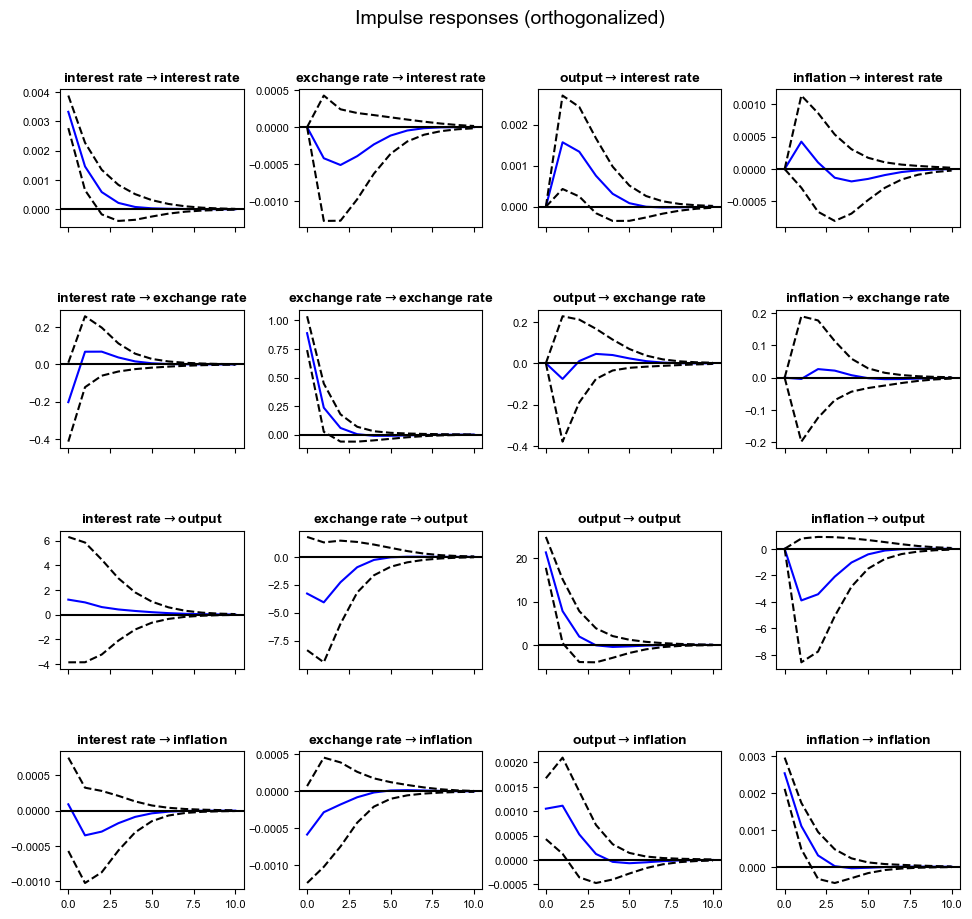

In [5]:
# Analyze impulse response functions with renamed variables
irf_renamed = var_results_renamed.irf(10)  # Analyze the effect over 10 periods

# Set figure size
plt.figure(figsize=(14, 10))

# Plot the impulse response functions
irf_plot = irf_renamed.plot(orth=True)  # Use orthogonalized impulses

# Improve the overall aesthetics
sns.set_style('whitegrid')

# Adjust individual plot parameters to prevent overlapping titles and labels
for i, ax in enumerate(irf_plot.axes):
    # Improve spacing and font sizes for clarity
    ax.set_title(ax.get_title(), fontsize=10, fontweight='bold')
    ax.xaxis.label.set_visible(False)  # Hide x-axis labels to prevent overlap
    ax.yaxis.label.set_visible(False)  # Hide y-axis labels to prevent overlap
    ax.tick_params(labelsize=8)       # Reduce tick label size for space

# Tweak overall spacing between plots in the grid
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.6, wspace=0.3)

# Show the updated plot
plt.show()


**MODEL STABILITY**

The code provides a confirmation of the model's stability, which suggests reliable forecasting. The model assesses how past values of the defined variables correlate over time. Overall we find a significant positive persistence in interest rates and exchange rates, indicating they influence their own future values. Output and inflation are also significantly influenced by their own past, revealing a pattern of self-reinforcement within the variables. The correlation matrix suggests that the residuals are sufficiently independent of each other, supporting the model's validity.

In [6]:
# Fit the VAR model
var_model = VAR(mona_data_for_var_renamed)  # Make sure to use the dataset with the renamed variables
var_results = var_model.fit(maxlags=2, ic='aic')

# Check if the model is stable
is_model_stable = var_results.is_stable()
print(f"Model is stable: {is_model_stable}")

# If the model is unstable, increase the number of lags
if not is_model_stable:
    # Try with more lags and check the stability of each model
    for i in range(1, 6):  # Assumption: Check up to 5 lags
        var_results = var_model.fit(i)
        if var_results.is_stable():
            print(f"Model with {i} lags is stable.")
            break
    else:
        print("No stable model found for up to 5 lags.")

# Print the results with renamed variables
summary = str(var_results.summary())
for original, rename in variable_rename_map.items():
    summary = summary.replace(original, rename)

print(summary)

Model is stable: True
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Apr, 2024
Time:                     15:19:33
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -16.5629
Nobs:                     69.0000    HQIC:                  -16.9536
Log likelihood:           222.134    FPE:                3.35763e-08
AIC:                     -17.2105    Det(Omega_mle):     2.53806e-08
--------------------------------------------------------------------
Results for equation interest rate
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.001312         0.000748           -1.753           0.080
L1.interest rate         0.404312         0.101673            3.977           0.000
L1.exchange rate  

**CONCLUSION**

We have utilised a VAR model to explore the interactions between economic indicators such as interest rates, output, exchange rate, and inflation from the MONA dataset. The VAR model was chosen for its effectiveness in capturing the dynamic relationships among these variables, crucial to depict the dynamics of economic fluctuations.

Our approach involved detailed data preparation, where we structured the data by transposing and cleaning it to ensure accuracy and completeness. We addressed challenges such as non-stationarity and missing values, ensuring that our dataset was robust for econometric analysis.

The insights derived from our model highlight the interplay of these economic variables, providing a nuanced understanding of their impacts over time. For example, the responsiveness of the interest rate to shifts in other indicators offers valuable perspectives on potential monetary policy adjustments.

This data project has highlighted the importance of detailed data structuring and econometric modeling in our economic research. 
Overall we can conclude that increases in interest rates affect interest rates positively in future periods, whilst suppressing output and inflation, and having minimal effect on the exchange rates. These are vital results that the Danish Central Bank must have in consideration when structuring their monetary policy.